- [0] features torch.Size([3, 16, 256, 256, 256])
- [1] p torch.Size([3, 1, 1, 50000, 3])
- [1] d 7 torch.Size([7, 3])
- [2] p torch.Size([3, 1, 7, 50000, 3])
- [1] f torch.Size([3, 497, 1, 7, 50000])
- [2] f torch.Size([3, 3479, 50000])
- [3] f torch.Size([3, 3482, 50000])
- [1] out torch.Size([3, 50000])

In [1]:
%reload_ext autoreload
%autoreload 2

In [14]:
import wandb
import torch as th
import numpy as np
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from sklearn.neighbors import KDTree

from model import NDF
from datasets import Shape2D, voxelize
from algorithms import dense_point_generation


import lovely_tensors as lt
lt.monkey_patch()

# Generate random dataset

In [24]:
Shape2D.generate_dataset(size=10, n_points=100, sigmas=[0.8, 0.02, 0.003, 0], sigmas_p=[.1, .3, .3, .3], res=64, folder='data', split=[.8, .1, .1], unif_ratio=.2)

Generating data:   0%|          | 0/10 [00:00<?, ?it/s]

# Visualize

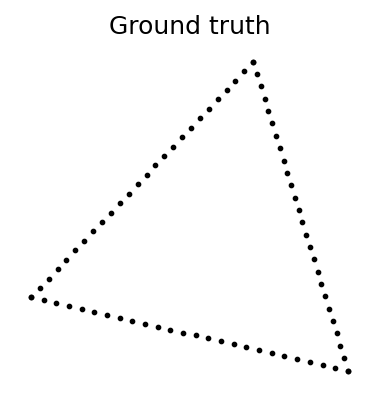

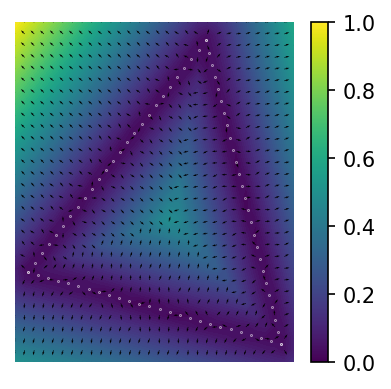

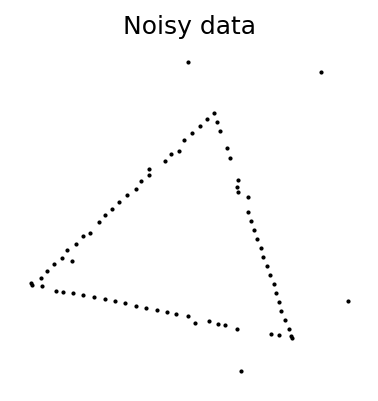

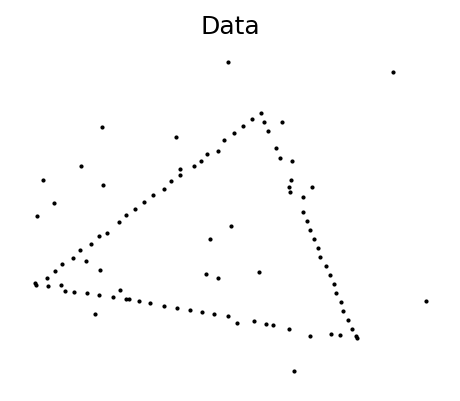

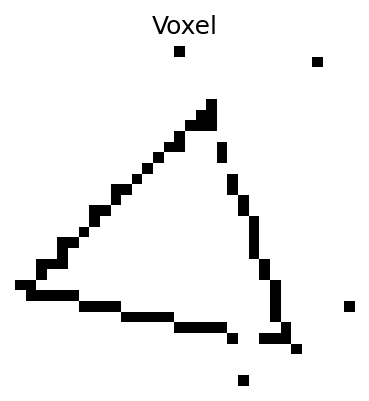

In [12]:
shape = Shape2D.generate_open_shape(unif_ratio=.2)
res = 32

data = shape['data']
gt_data = shape['gt_data']
noisy_data = shape['noisy_data']
voxel = shape['vox']
corners = shape['corners']

space = np.linspace(-1.1, 1.1, res)
X1, X2 = np.meshgrid(space, space)
X = np.stack([X1, X2], axis=-1).reshape(-1, 2)

# ground truth
plt.figure(figsize=(3, 3), dpi=150)
plt.scatter(gt_data[:, 0], gt_data[:, 1], c='k', s=3)
plt.axis('off')
plt.title('Ground truth')
plt.show()

# Distance fields
tree = KDTree(gt_data)
dist, idx = tree.query(X, k=1)
idx = idx.squeeze()
dist = dist.reshape(res, res)

grad = np.stack([
    X[:, 0]-gt_data[idx, 0],
    X[:, 1]-gt_data[idx, 1],
], axis=-1)
grad /= np.linalg.norm(grad, axis=-1, keepdims=True)

plt.figure(figsize=(3, 3), dpi=150)
plt.contourf(X1, X2, dist, levels=100, cmap='viridis')
plt.quiver(X[:, 0], X[:, 1], grad[:, 0], grad[:, 1], color='k')
plt.scatter(gt_data[:, 0], gt_data[:, 1], c='w', s=.05)
plt.colorbar()
plt.axis('off')
plt.xlim(-1.1, 1.1)
plt.ylim(-1.1, 1.1)
plt.show()

# Noisy data
plt.figure(figsize=(3, 3), dpi=150)
plt.scatter(noisy_data[:, 0], noisy_data[:, 1], c='k', s=1)
plt.axis('off')
plt.title('Noisy data')
plt.show()

# Data
plt.figure(figsize=(3.7, 3), dpi=150)
plt.scatter(data[:, 0], data[:, 1], c='k', s=1)
plt.axis('off')
plt.title('Data')
plt.show()

# Voxel
filtered_vox = voxelize(noisy_data, res=32)
plt.figure(figsize=(3, 3), dpi=150)
plt.imshow(1-filtered_vox.T, cmap='gray', origin='lower')
plt.axis('off')
plt.title('Voxel')
plt.show()

# Train the model

In [25]:
train_dataloader = th.utils.data.DataLoader(
    Shape2D(folder='data', mode='train'), batch_size=10, shuffle=True)
val_dataloader = th.utils.data.DataLoader(
    Shape2D(folder='data', mode='val'), batch_size=4, shuffle=False)

model = NDF(loss='l2', lr=1e-4, clamp=True)

wandb_logger = WandbLogger(project='ndf')
checkpoint_callback = ModelCheckpoint(
    dirpath=f'checkpoints/{wandb.run.name}', save_top_k=5, monitor='val_loss')
ei_early_stop = EarlyStopping(monitor='val_loss', patience=2)

trainer = pl.Trainer(accelerator='gpu', devices=[1], max_epochs=100,
                        logger=wandb_logger, callbacks=[
    checkpoint_callback, ei_early_stop])

trainer.fit(model, train_dataloader, val_dataloader)

/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/pytorch_lightning/loggers/wandb.py:395: UserWarning: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
  rank_zero_warn(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:613: UserWarning: Checkpoint directory /home/lamsade/lmarandat/3D

Sanity Checking: 0it [00:00, ?it/s]

/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/lamsade/lmarandat/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:1609: PossibleUserWarning: The number of training batches (1) is smaller than the logg

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# Test

iter 1: 0.00%
iter 2: 10.31%
iter 3: 23.74%
iter 4: 39.74%
iter 5: 59.24%
iter 6: 82.51%


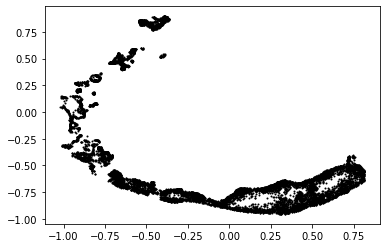

In [30]:
test_dataloader = th.utils.data.DataLoader(Shape2D(folder='data', mode='train'), batch_size=2, shuffle=False)
it = iter(test_dataloader)
data, vox, dist = next(it)
data, vox, dist = data[0], vox[0], dist[0]

points = dense_point_generation(model, vox, n=10_000, delta=0.01)
plt.scatter(points[:, 0], points[:, 1], c='k', s=1)